# Signal Construction
**Objective:** Build cross-sectional momentum and mean-reversion signals

**Universe:** 25 liquid cryptocurrencies (expanded for robustness)

**Strategies:**
1. **Momentum (20-day):** Long recent winners, short recent losers
2. **Reversal (1-day):** Long recent losers, short recent winners
3. **Filtered Reversal:** Reversal only on low-volatility coins

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('.')

from utils import *

# Load data
px = pd.read_csv('data_px.csv', index_col=0, parse_dates=True)
ret = pd.read_csv('data_ret.csv', index_col=0, parse_dates=True)
elig = pd.read_csv('data_elig.csv', index_col=0, parse_dates=True)

print(f"Data loaded: {ret.shape[0]} days × {ret.shape[1]} coins")
print(f"Period: {ret.index[0].date()} to {ret.index[-1].date()}")

Data loaded: 2229 days × 25 coins
Period: 2019-12-31 to 2026-02-05


## 1. Momentum Strategy (20-day)
Hypothesis: Recent winners continue to outperform over medium horizons

In [2]:
# Calculate momentum signal
hor_mom = 20

mom_signal = ret.rolling(hor_mom, min_periods=hor_mom).mean()
mom_signal = mom_signal.where(elig)

# Convert to portfolio weights: rank → demean → normalize
mom_port = rank_signal_xs(mom_signal, elig)
mom_port = demean_xs(mom_port)
mom_port = normalize_weights(mom_port)

print(f"Momentum strategy created (horizon={hor_mom} days)")
print(f"Market neutral: sum(w) = {mom_port.iloc[-1].sum():.3f}")
print(f"Fully invested: sum(|w|) = {mom_port.iloc[-1].abs().sum():.3f}")

Momentum strategy created (horizon=20 days)
Market neutral: sum(w) = 0.000
Fully invested: sum(|w|) = 1.000


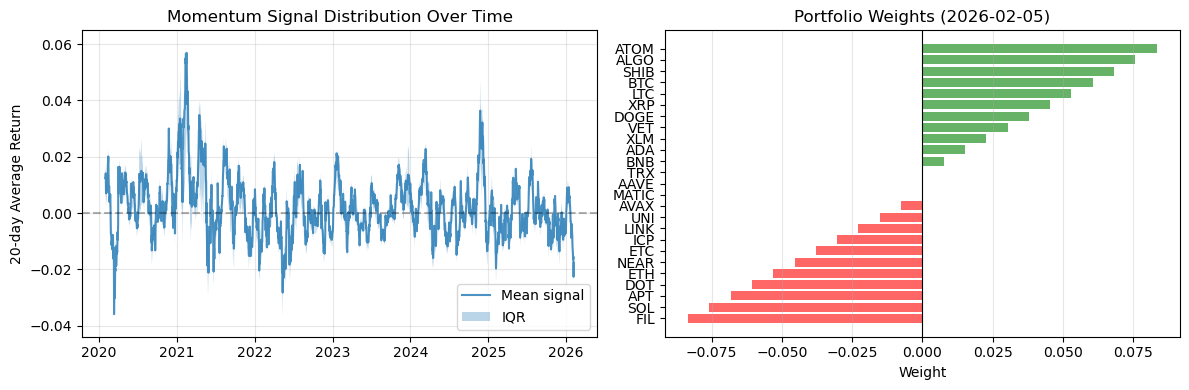

In [3]:
# Visualize momentum signal distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Signal over time
axes[0].plot(mom_signal.index, mom_signal.mean(axis=1), label='Mean signal', alpha=0.8)
axes[0].fill_between(mom_signal.index, 
                       mom_signal.quantile(0.25, axis=1),
                       mom_signal.quantile(0.75, axis=1),
                       alpha=0.3, label='IQR')
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].set_title('Momentum Signal Distribution Over Time')
axes[0].set_ylabel('20-day Average Return')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Current weights
last_weights = mom_port.iloc[-1].sort_values()
colors = ['red' if x < 0 else 'green' for x in last_weights]
axes[1].barh(range(len(last_weights)), last_weights, color=colors, alpha=0.6)
axes[1].set_yticks(range(len(last_weights)))
axes[1].set_yticklabels(last_weights.index)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title(f'Portfolio Weights ({ret.index[-1].date()})')
axes[1].set_xlabel('Weight')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('momentum_signal.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Reversal Strategy (1-day)
Hypothesis: Short-term losers bounce back (mean reversion)

In [4]:
# Calculate reversal signal (flip sign)
hor_rev = 1

rev_signal = -1.0 * ret.rolling(hor_rev, min_periods=1).mean()

# Convert to portfolio weights
rev_port = rank_signal_xs(rev_signal, elig)
rev_port = demean_xs(rev_port)
rev_port = normalize_weights(rev_port)

print(f"Reversal strategy created (horizon={hor_rev} day)")

Reversal strategy created (horizon=1 day)


## 3. Activity-Filtered Reversal
Enhancement: Only trade reversal when volatility is low (below median)

In [5]:
# Calculate activity filter (realized volatility)
lookback = 20
q = 0.50  # Median split

rv = ret.rolling(lookback, min_periods=lookback).std()
rv_elig = rv.where(elig)
thr = rv_elig.quantile(q, axis=1)
low_activity = rv_elig.lt(thr, axis=0)

# Apply filter with masked operations
mask = low_activity & elig
rev_port_filt = demean_xs_masked(rev_port, mask)
rev_port_filt = normalize_weights_masked(rev_port_filt, mask)

print(f"Filtered reversal strategy created")
print(f"Average active coins per day: {(rev_port_filt != 0).sum(axis=1).mean():.1f}")
print(f"Fraction of days with positions: {(rev_port_filt.abs().sum(axis=1) > 0).mean():.1%}")

Filtered reversal strategy created
Average active coins per day: 9.4
Fraction of days with positions: 98.7%


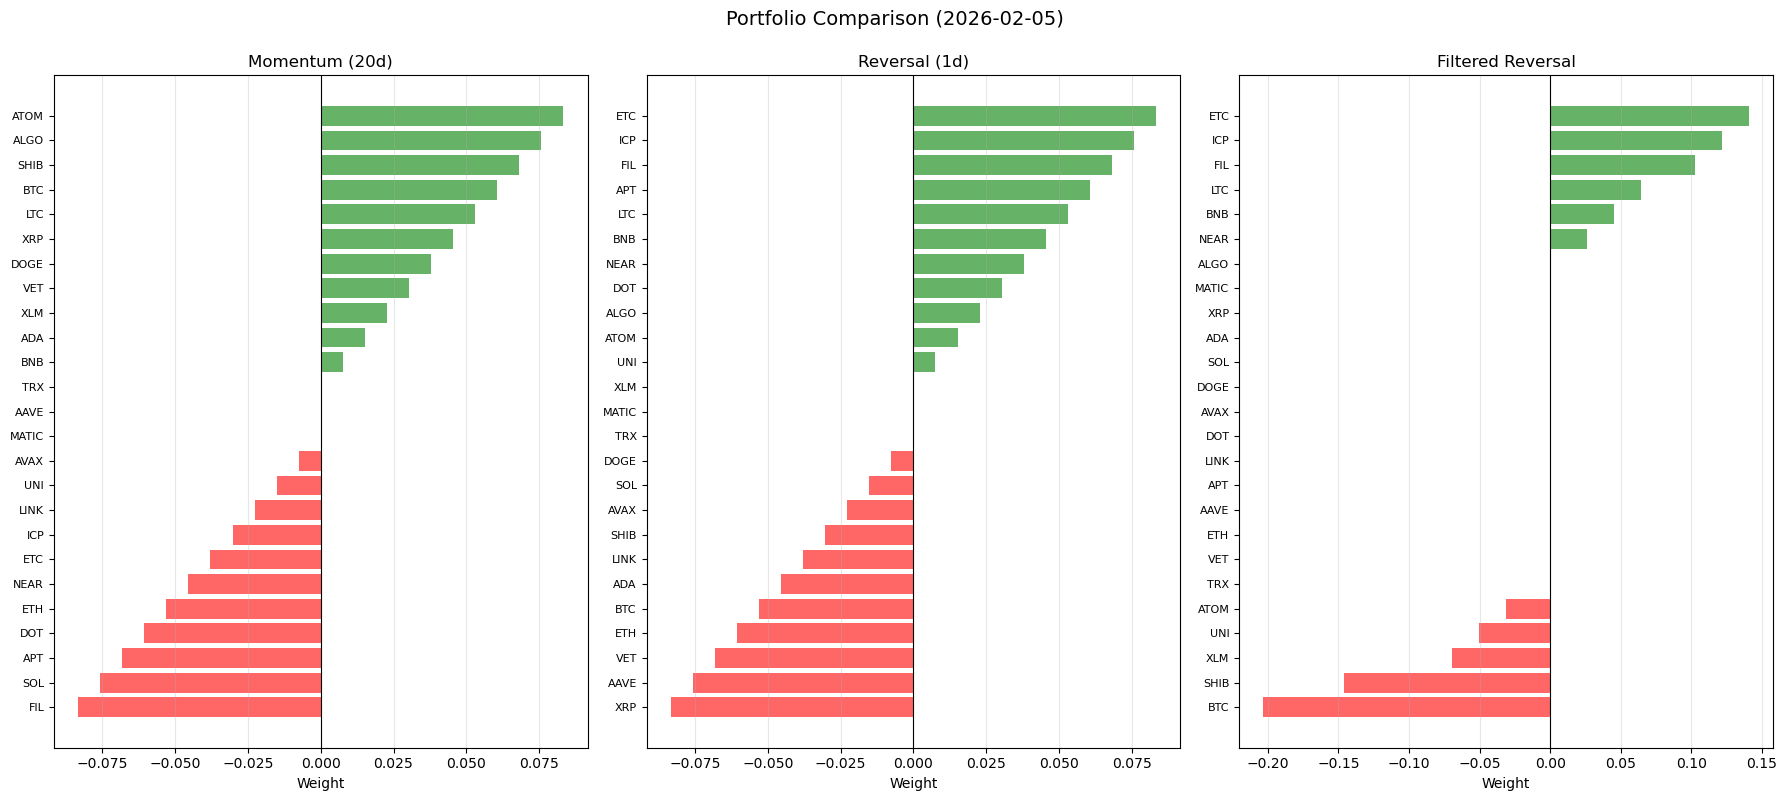


Signal construction complete. Proceed to backtesting.


In [6]:
# Visualize strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

strategies = [
    ('Momentum (20d)', mom_port),
    ('Reversal (1d)', rev_port),
    ('Filtered Reversal', rev_port_filt)
]

for i, (name, port) in enumerate(strategies):
    last_w = port.iloc[-1].sort_values()
    colors = ['red' if x < 0 else 'green' for x in last_w]
    
    axes[i].barh(range(len(last_w)), last_w, color=colors, alpha=0.6)
    axes[i].set_yticks(range(len(last_w)))
    axes[i].set_yticklabels(last_w.index, fontsize=8)  # Smaller font for 25 coins
    axes[i].axvline(0, color='black', linestyle='-', linewidth=0.8)
    axes[i].set_title(name, fontsize=12)
    axes[i].set_xlabel('Weight', fontsize=10)
    axes[i].grid(alpha=0.3, axis='x')

plt.suptitle(f'Portfolio Comparison ({ret.index[-1].date()})', y=0.995, fontsize=14)
plt.tight_layout()
plt.savefig('portfolio_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSignal construction complete. Proceed to backtesting.")